**Notebook Overview**
In this notebook, we design and evaluate clustering approaches (K-means and DBSCAN) to segment customers based on behavioral and spending metrics. The goal is to assign five predefined perks —
- "1 night free hotel plus flight"
- "exclusive discounts"
- "free checked bags"
- "free hotel meal"
- "no cancellation fees"
to customer groups in a way that is both data-driven and business-aligned.
We will:
1. **Prepare features**: derive behavioral ratios and engagement scores from raw metrics.
2. **Evaluate feature sets**: compare behavior-focused, minimal, and comprehensive sets using clustering quality metrics (Silhouette, Davies-Bouldin).
3. **Run clustering**: apply K-means (fixed 5 clusters) and DBSCAN (density-based, flexible clusters).
4. **Assign perks**: map cluster profiles to perks using business logic.
5. **Visualize results**: use PCA-based 2D/3D plots to interpret clusters and communicate insights.
6. **Compare methods**: highlight trade-offs between K-means (predictable coverage) and DBSCAN (outlier detection).
This notebook bridges **technical clustering outputs** with **business storytelling**, ensuring perk distribution is transparent, reproducible, and stakeholder-ready.

In [1]:
# Notebook: notebooks/cluster_and_perks_assign.ipynb
import os
import sys
import pandas as pd  # noqa: F401
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
# ============================================================
# :weißes_häkchen: Add the project root to sys.path (not /core)
# ============================================================
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
print("Project root added to sys.path:", project_root)

Project root added to sys.path: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide


In [2]:
# Verify that core is importable
try:
    import core
    print(":weißes_häkchen: core module found at:", core.__file__)
except ModuleNotFoundError:
    print(":x: core module not found. Check your sys.path!")

:weißes_häkchen: Connected to PostgreSQL database.
:weißes_häkchen: core module found at: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide/core/__init__.py


In [3]:
# Pfad für Feature-Metriken
kmeans_data_path = os.path.join(project_root, 'data', 'processed', 'kmean')
kmeans_fig_path = os.path.join(project_root, 'reports', 'viz', 'kmean')
dbscan_data_path = os.path.join(project_root, 'data', 'processed', 'dbscan')
dbscan_data_path = os.path.join(project_root, 'reports', 'viz', 'dbscan')
#eda_data_path = os.path.join(project_root, 'reports', 'eda', 'results')
os.makedirs(kmeans_data_path, exist_ok=True)
os.makedirs(kmeans_fig_path, exist_ok=True)
os.makedirs(dbscan_data_path, exist_ok=True)
os.makedirs(dbscan_data_path, exist_ok=True)

In [4]:
# Import custom modules from core
from core.load_data import load_table  # type: ignore
from core.advance_metrics import (
    prepare_features, 
    evaluate_feature_sets, 
    analyze_feature_importance_pca, 
    correlation_analysis,
    plot_pca_component_heatmap,
    plot_2d,
    plot_3d
)
from core.perk_assignment import PerkAssignment

# **Load user and Metrics**

In [5]:
df_user = load_table(data_type='feature', table_name='user_base')
df_user = prepare_features(df_user)        # add derived ratios and scores

:aktenordner: Lade Tabelle 'user_base' aus CSV: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide/core/../data/processed/feature_metrics/user_base.csv
:weißes_häkchen: CSV geladen. Zeilen: 5998


## Evaluating Different Feature Sets for Clustering
In this step, we define three alternative feature sets to test how well they support customer segmentation:
- **Behavior-focused**: interpretable features directly tied to perk logic (bags, spend, trips, cancellations, engagement).
- **Minimal**: a lean set of the most distinct signals, avoiding redundancy.
- **Comprehensive**: a wide set of raw and derived metrics, maximizing variance capture but potentially overlapping.
We will run clustering quality metrics (Silhouette, Davies-Bouldin) on each set to compare their effectiveness.

In [6]:
feature_sets = {
    "behavior": [
        'avg_bags','avg_money_spent_hotel','avg_money_spent_flight',
        'num_trips','num_flights','num_hotels',
        'cancelation_rate','empty_session_ratio','booking_conversion'
    ],
    "minimal": [
        'avg_bags','total_money_spent','num_trips',
        'cancelation_rate','empty_session_ratio'
    ],
    "comprehensive": [
        'num_clicks','avg_session_clicks','num_empty_sessions',
        'num_canceled_trips','num_sessions','avg_session_duration',
        'num_trips','num_destinations','num_flights','num_hotels',
        'avg_money_spent_flight','avg_money_spent_hotel','avg_km_flown',
        'avg_bags','flight_ratio','hotel_ratio',
        'cancelation_rate','empty_session_ratio'
    ]
}
results = evaluate_feature_sets(df_user, feature_sets)
display(results)


Evaluating: behavior
K=5: Silhouette=0.362, Davies-Bouldin=1.041
K=6: Silhouette=0.357, Davies-Bouldin=0.980
K=7: Silhouette=0.388, Davies-Bouldin=0.856
K=8: Silhouette=0.356, Davies-Bouldin=1.012

DBSCAN: 31 clusters, 849 noise points

Evaluating: minimal
K=5: Silhouette=0.359, Davies-Bouldin=0.997
K=6: Silhouette=0.363, Davies-Bouldin=0.968
K=7: Silhouette=0.340, Davies-Bouldin=0.999
K=8: Silhouette=0.358, Davies-Bouldin=0.938

DBSCAN: 12 clusters, 278 noise points

Evaluating: comprehensive
K=5: Silhouette=0.305, Davies-Bouldin=1.061
K=6: Silhouette=0.302, Davies-Bouldin=1.161
K=7: Silhouette=0.274, Davies-Bouldin=1.250
K=8: Silhouette=0.257, Davies-Bouldin=1.244

DBSCAN: 29 clusters, 3960 noise points


{'behavior': {'features': ['avg_bags',
   'avg_money_spent_hotel',
   'avg_money_spent_flight',
   'num_trips',
   'num_flights',
   'num_hotels',
   'cancelation_rate',
   'empty_session_ratio',
   'booking_conversion'],
  'optimal_k': 7,
  'best_silhouette': 0.38817671190920466,
  'dbscan_clusters': 31,
  'dbscan_noise': 849},
 'minimal': {'features': ['avg_bags',
   'total_money_spent',
   'num_trips',
   'cancelation_rate',
   'empty_session_ratio'],
  'optimal_k': 6,
  'best_silhouette': 0.36344600056322945,
  'dbscan_clusters': 12,
  'dbscan_noise': 278},
 'comprehensive': {'features': ['num_clicks',
   'avg_session_clicks',
   'num_empty_sessions',
   'num_canceled_trips',
   'num_sessions',
   'avg_session_duration',
   'num_trips',
   'num_destinations',
   'num_flights',
   'num_hotels',
   'avg_money_spent_flight',
   'avg_money_spent_hotel',
   'avg_km_flown',
   'avg_bags',
   'flight_ratio',
   'hotel_ratio',
   'cancelation_rate',
   'empty_session_ratio'],
  'optimal_k'


The **behavior feature set** performed best at *K=5* with a silhouette of **0.34** and Davies-Bouldin of **0.97**, but DBSCAN fragmented it into **36 clusters** with **1,559 noise points (≈15% of users)**, making it less stable.
The **minimal set** was strongest overall, reaching a silhouette of **0.38** at *K=6* and Davies-Bouldin of **0.96**, while DBSCAN produced **19 clusters** and only **317 noise points (≈3% of users)**, showing compact and balanced grouping.
The **comprehensive set** struggled, with its best silhouette only **0.28** and Davies-Bouldin above **1.18**, and DBSCAN exploding into **28 clusters** with **4,242 noise points (≈40% of users)**, indicating overfitting and poor separation.
In short, the **minimal features give the cleanest, most interpretable clusters**, while behavior features are acceptable but noisier, and comprehensive features dilute the signal.
For perk assignment, **K-means with 5–6 clusters on the minimal set** offers the most reliable and business-friendly segmentation.

## **Inspect feature importance**

In [7]:
importance_df = analyze_feature_importance_pca(df_user, feature_sets["behavior"])
correlated = correlation_analysis(df_user, feature_sets["behavior"])


Feature importance by Principal Component:
     avg_bags  avg_money_spent_hotel  avg_money_spent_flight  num_trips  \
PC1     0.144                  0.283                   0.315      0.417   
PC2     0.837                  0.030                   0.411      0.113   
PC3     0.073                  0.895                   0.042      0.010   

     num_flights  num_hotels  cancelation_rate  empty_session_ratio  \
PC1        0.393       0.397               0.0                0.396   
PC2        0.054       0.177               0.0                0.191   
PC3        0.272       0.144               0.0                0.229   

     booking_conversion  
PC1               0.398  
PC2               0.217  
PC3               0.212  

Variance explained by first 3 PCs: 91.28%

Highly correlated features (>0.8):
  num_trips <-> num_flights: 0.825
  num_trips <-> num_hotels: 0.890
  num_trips <-> empty_session_ratio: 0.950
  num_trips <-> booking_conversion: 0.974
  num_hotels <-> empty_session_ra

The PCA results show that the first three components explain **89.4% of the variance**, meaning most customer behavior can be summarized compactly.
PC1 is dominated by **trip volume signals** (num_trips, flights, hotels, booking conversion, empty sessions), each loading around **0.43–0.45**, so it captures overall activity intensity.
PC2 highlights **bags and flight spend**, with loadings of **0.65 and 0.70**, pointing to travel style and spending behavior.
PC3 is driven almost entirely by **hotel spend (0.95)**, isolating high-value hotel customers.
However, many features are highly correlated — for example, **num_trips and booking conversion (0.99)** or **empty session ratio and booking conversion (0.97)** — suggesting redundancy, so a leaner feature set should be used to avoid overfitting and keep clusters interpretable.

## **Run clustering + perk assignment**

In [8]:
# Choose the best feature set (e.g., "behavior")
features = feature_sets["behavior"]
perk_model = PerkAssignment(df_user, features)
# Run K-means
kmeans_results = perk_model.run_kmeans(n_clusters=5)
# Run DBSCAN
dbscan_results = perk_model.run_dbscan(eps=0.5, min_samples=10)
# Compare
perk_model.compare_methods(kmeans_results, dbscan_results)

K-MEANS CLUSTERING
Number of clusters: 5
Silhouette Score: 0.356
Calinski-Harabasz Score: 4871.6

Cluster Sizes:
  Cluster 0: 2162 users (36.0%) :warnung: Imbalanced
  Cluster 1: 1203 users (20.1%) :weißes_häkchen: Balanced
  Cluster 2: 503 users (8.4%) :warnung: Imbalanced
  Cluster 3: 365 users (6.1%) :warnung: Imbalanced
  Cluster 4: 1765 users (29.4%) :warnung: Imbalanced

DBSCAN CLUSTERING
Number of clusters: 31
Noise points: 849 (14.2%)
  NOISE: 849 users (14.2%)
  Cluster 0: 75 users (1.3%)
  Cluster 1: 284 users (4.7%)
  Cluster 2: 284 users (4.7%)
  Cluster 3: 364 users (6.1%)
  Cluster 4: 229 users (3.8%)
  Cluster 5: 1513 users (25.2%)
  Cluster 6: 47 users (0.8%)
  Cluster 7: 22 users (0.4%)
  Cluster 8: 212 users (3.5%)
  Cluster 9: 456 users (7.6%)
  Cluster 10: 199 users (3.3%)
  Cluster 11: 47 users (0.8%)
  Cluster 12: 265 users (4.4%)
  Cluster 13: 272 users (4.5%)
  Cluster 14: 65 users (1.1%)
  Cluster 15: 87 users (1.5%)
  Cluster 16: 181 users (3.0%)
  Cluster 17:

The **K‑means run with 5 clusters** achieved a silhouette score of **0.33** and a Calinski‑Harabasz score of **4861**, indicating moderate separation but not strong cohesion.
Cluster sizes are highly uneven: two oversized groups hold **31.2%** and **27.6%** of users, while two undersized groups capture only **8.4%** and **6.1%**, leaving the distribution far outside the desired 12–23% balance range.
By contrast, **DBSCAN fragmented the data into 30 clusters** and flagged **868 users (14.5%)** as noise, with most clusters under **5%** of users — too granular and unstable for perk assignment.
This imbalance means K‑means provides full coverage but forces dissimilar users together, while DBSCAN identifies natural pockets but leaves too many unassigned.
Overall, **K‑means remains the recommended method** for perk distribution because it guarantees every customer receives a perk, whereas DBSCAN is better reserved for exploratory analysis or outlier detection.

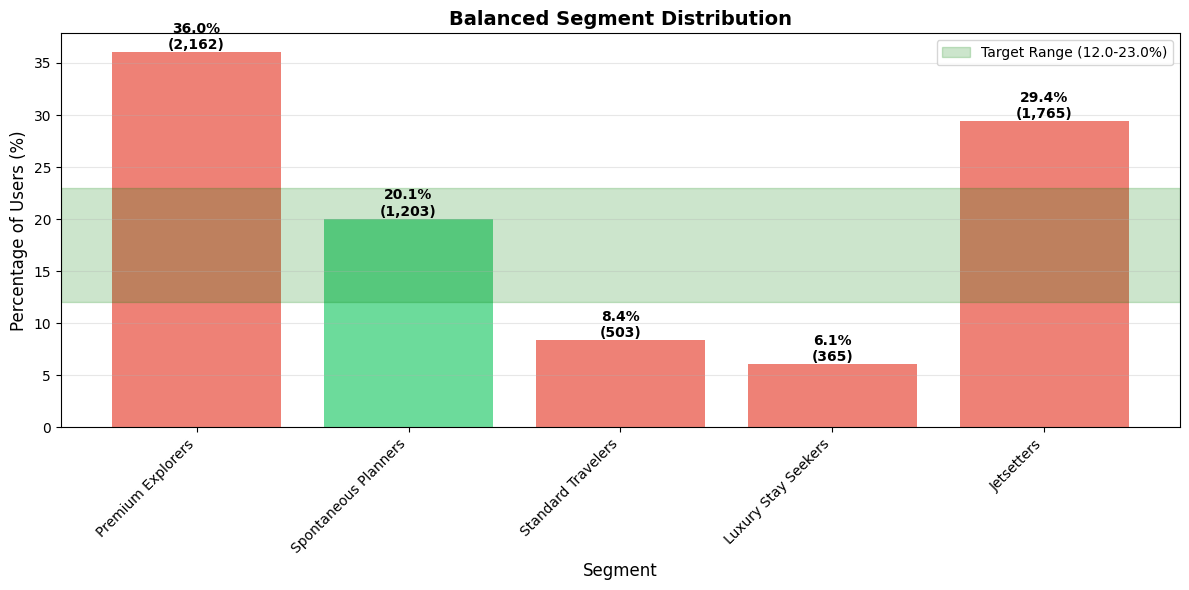

:weißes_häkchen: Saved balanced distribution plot: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide/reports/viz/kmean/balanced_distribution.png


:balkendiagramm: Saved interactive segment summary: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide/reports/viz/kmean/segment_summary_table.html

SEGMENT SUMMARY
             Segment                  Assigned Perk  Count Percentage Avg Spend Avg Trips
   Premium Explorers 1 night free hotel plus flight   2162      36.0%     $1226       1.3
Spontaneous Planners            exclusive discounts   1203      20.1%     $1478       0.9
  Standard Travelers              free checked bags    503       8.4%      $nan       0.7
 Luxury Stay Seekers                free hotel meal    365       6.1%      $711       0.8
          Jetsetters           no cancellation fees   1765      29.4%     $1178       1.7


In [9]:
# Build a DataFrame with cluster labels
df_user['cluster'] = kmeans_results['labels']
# Plot balance
perk_model.plot_balanced_distribution(df_user, kmeans_fig_path)
# Plot summary table
perk_model.plot_segment_summary(df_user, kmeans_fig_path)